In [25]:
# Analysis for news.db (e.g how many articles are there for each ticker)
import sys, os
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "../..")))
import config
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timezone
from tqdm import tqdm
from matplotlib.dates import DateFormatter
import ast
from collections import Counter
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})


In [2]:
df = pd.read_csv("../../"+config.NEWS_CSV_PATH_CLEAN)
# Quick info
print(f"Total rows: {len(df):,}")


Total rows: 280,428


In [3]:
# Step 1: Load EPS dataset
eps_df = pd.read_csv('../../'+config.EPS_DATA_CSV)

# Step 2: Get list of all tickers you're expecting coverage for
all_tickers = sorted(eps_df['Ticker'].dropna().unique())

In [23]:
def plot_article_counts_with_zeros(df_news, all_tickers, threshold=1000):
    """
    Plots number of articles per ticker (including tickers with 0 articles),
    sorted descending and shown on the y-axis for better readability.
    Also prints how many tickers have zero articles and how many fall below the threshold.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Count articles per ticker
    ticker_counts = df_news['Stock_symbol'].value_counts()

    # Ensure all expected tickers are included, fill missing with 0, and sort
    full_counts = pd.Series(index=all_tickers, data=0)
    full_counts.update(ticker_counts)
    full_counts = full_counts.sort_values(ascending=False)

    # Print summary stats
    num_zero = (full_counts == 0).sum()
    num_below = (full_counts < threshold).sum()
    print(f"[INFO] Tickers with 0 articles: {num_zero:,} / {len(all_tickers)}")
    print(f"[INFO] Tickers with < {threshold} articles: {num_below:,} / {len(all_tickers)}")

    # Calculate figure height
    n = len(full_counts)
    height_per_ticker = 0.3
    fig_height = max(6, min(20, n * height_per_ticker))

    # Plot
    fig, ax = plt.subplots(figsize=(10, fig_height))
    bars = ax.barh(full_counts.index, full_counts.values)

    # Add labels for tickers with zero articles
    for bar, count in zip(bars, full_counts.values):
        if count == 0:
            ax.text(count + 5, bar.get_y() + bar.get_height() / 2,
                    r"$0$", va='center', color='gray', fontsize=8)

    # Vertical line at threshold, with legend
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=1.5,
               label=fr"$n = {threshold}$")
    ax.legend(loc='upper right')

    # Labels with LaTeX style
    ax.set_title(r"\textbf{Number of Articles per Ticker} (including $0$s)", fontsize=14)
    ax.set_xlabel(r"Number of Articles", fontsize=12)
    ax.set_ylabel(r"Ticker", fontsize=12)

    # Tighten vertical space
    ax.set_ylim(-0.5, len(full_counts) - 0.5)

    # Adjust layout
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)
    plt.show()


[INFO] Tickers with 0 articles: 36 / 157
[INFO] Tickers with < 100 articles: 46 / 157


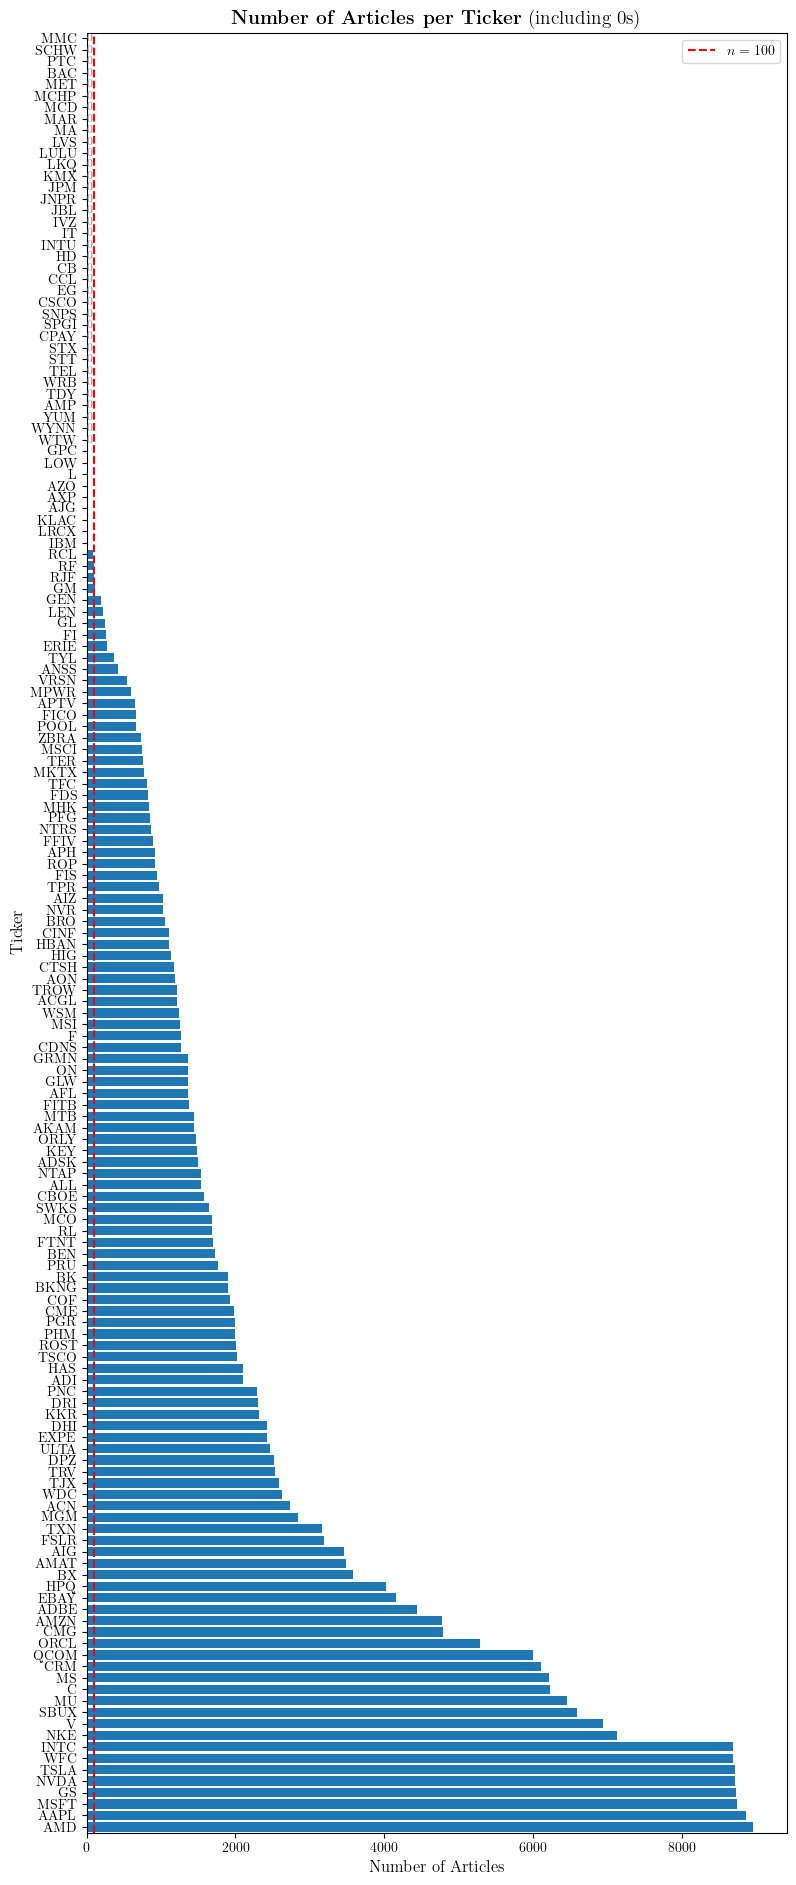

In [26]:

plot_article_counts_with_zeros(df, all_tickers, threshold=100)

In [6]:
def datetime_to_year_quarter(dt):
    """
    Convert a datetime or string in 'YYYY-MM-DD HH:MM:SS UTC' format
    to a (year, quarter) tuple.
    """
    try:
        if isinstance(dt, str):
            dt = datetime.strptime(dt.strip().replace(" UTC", ""), "%Y-%m-%d %H:%M:%S")
        elif isinstance(dt, pd.Timestamp) or isinstance(dt, datetime):
            pass  # Already a datetime object
        else:
            raise ValueError("Unsupported type")

        quarter = (dt.month - 1) // 3 + 1
        return (dt.year, quarter)
    except Exception as e:
        print(f"[ERROR] Failed to parse: {dt}")
        return None

In [27]:
def plot_article_distribution_by_quarter(df, ticker):
    """
    For a given ticker, plot a histogram showing the number of related articles over time (by quarter).
    """

    # Filter to rows matching the given ticker
    filtered_df = df[df['Stock_symbol'] == ticker].copy()

    if filtered_df.empty:
        print(f"[INFO] No articles found for ticker '{ticker}'.")
        return

    # Convert dates to (year, quarter)
    filtered_df['Year_Quarter'] = filtered_df['Date'].apply(datetime_to_year_quarter)

    # Drop rows where conversion failed
    filtered_df = filtered_df.dropna(subset=['Year_Quarter'])

    # Count articles per (year, quarter)
    counts = Counter(filtered_df['Year_Quarter'])

    # Sort keys chronologically
    sorted_keys = sorted(counts.keys())
    labels = [f"{year}~Q{q}" for (year, q) in sorted_keys]  # use ~ for nice spacing
    values = [counts[k] for k in sorted_keys]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values)

    plt.title(rf"\textbf{{Article Distribution for}} {ticker} \textbf{{by Quarter}}", fontsize=14)
    plt.xlabel(r"Year--Quarter", fontsize=12)
    plt.ylabel(r"Number of Articles", fontsize=12)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()


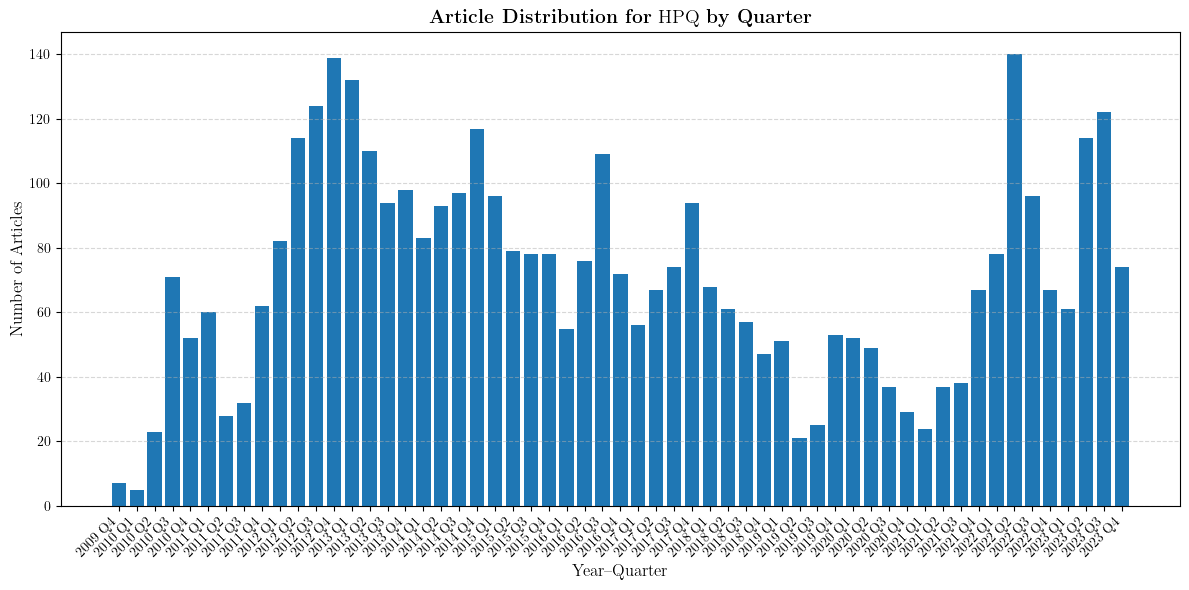

In [29]:
plot_article_distribution_by_quarter(df=df,ticker="HPQ")

In [31]:
def plot_article_coverage_span(df, all_tickers):
    """
    Plot the duration (earliest to latest article) for each ticker.
    X-axis shows coverage in days, but ticks are formatted as years/months.
    """
    print("[INFO] Calculating article coverage span per ticker...")
    
    # Ensure proper datetime parsing
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    durations = []

    for ticker in all_tickers:
        ticker_df = df[df['Stock_symbol'] == ticker]
        if ticker_df.empty:
            durations.append((ticker, 0))
        else:
            delta_days = (ticker_df['Date'].max() - ticker_df['Date'].min()).days
            durations.append((ticker, delta_days))

    # Sort tickers by duration descending
    durations.sort(key=lambda x: x[1], reverse=True)
    tickers_sorted, days_sorted = zip(*durations)

    # Plot
    fig_height = max(6, min(0.25 * len(tickers_sorted), 20))
    fig, ax = plt.subplots(figsize=(12, fig_height))

    ax.barh(tickers_sorted, days_sorted, height=0.4)
    ax.set_xlabel(r"Coverage Duration", fontsize=12)
    ax.set_ylabel(r"Ticker", fontsize=12)
    ax.set_title(r"\textbf{Time Span of Articles per Ticker}", fontsize=14)

    # Format x-axis ticks into years/months/days
    def days_to_label(days):
        years = days // 365
        months = (days % 365) // 30
        return rf"${years}\,\mathrm{{y}}\,{months}\,\mathrm{{m}}$" if years or months else rf"${days}\,\mathrm{{d}}$"

    tick_locs = ax.get_xticks()
    ax.set_xticklabels([days_to_label(int(x)) for x in tick_locs])

    ax.grid(True, linestyle='--', alpha=0.3, axis='x')

    # Remove top and bottom whitespace
    ax.set_ylim(-0.5, len(tickers_sorted) - 0.5)

    plt.tight_layout()
    plt.show()

    print(f"[INFO] Tickers with 0-day range: {(pd.Series(days_sorted) == 0).sum()}")
    print(f"[INFO] Max range: {max(days_sorted):,} days, Min: {min(days_sorted):,} days")


[INFO] Calculating article coverage span per ticker...


/var/folders/vn/mzcbmnv93_z0291brswcw9fw0000gn/T/ipykernel_91292/1282466391.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([days_to_label(int(x)) for x in tick_locs])


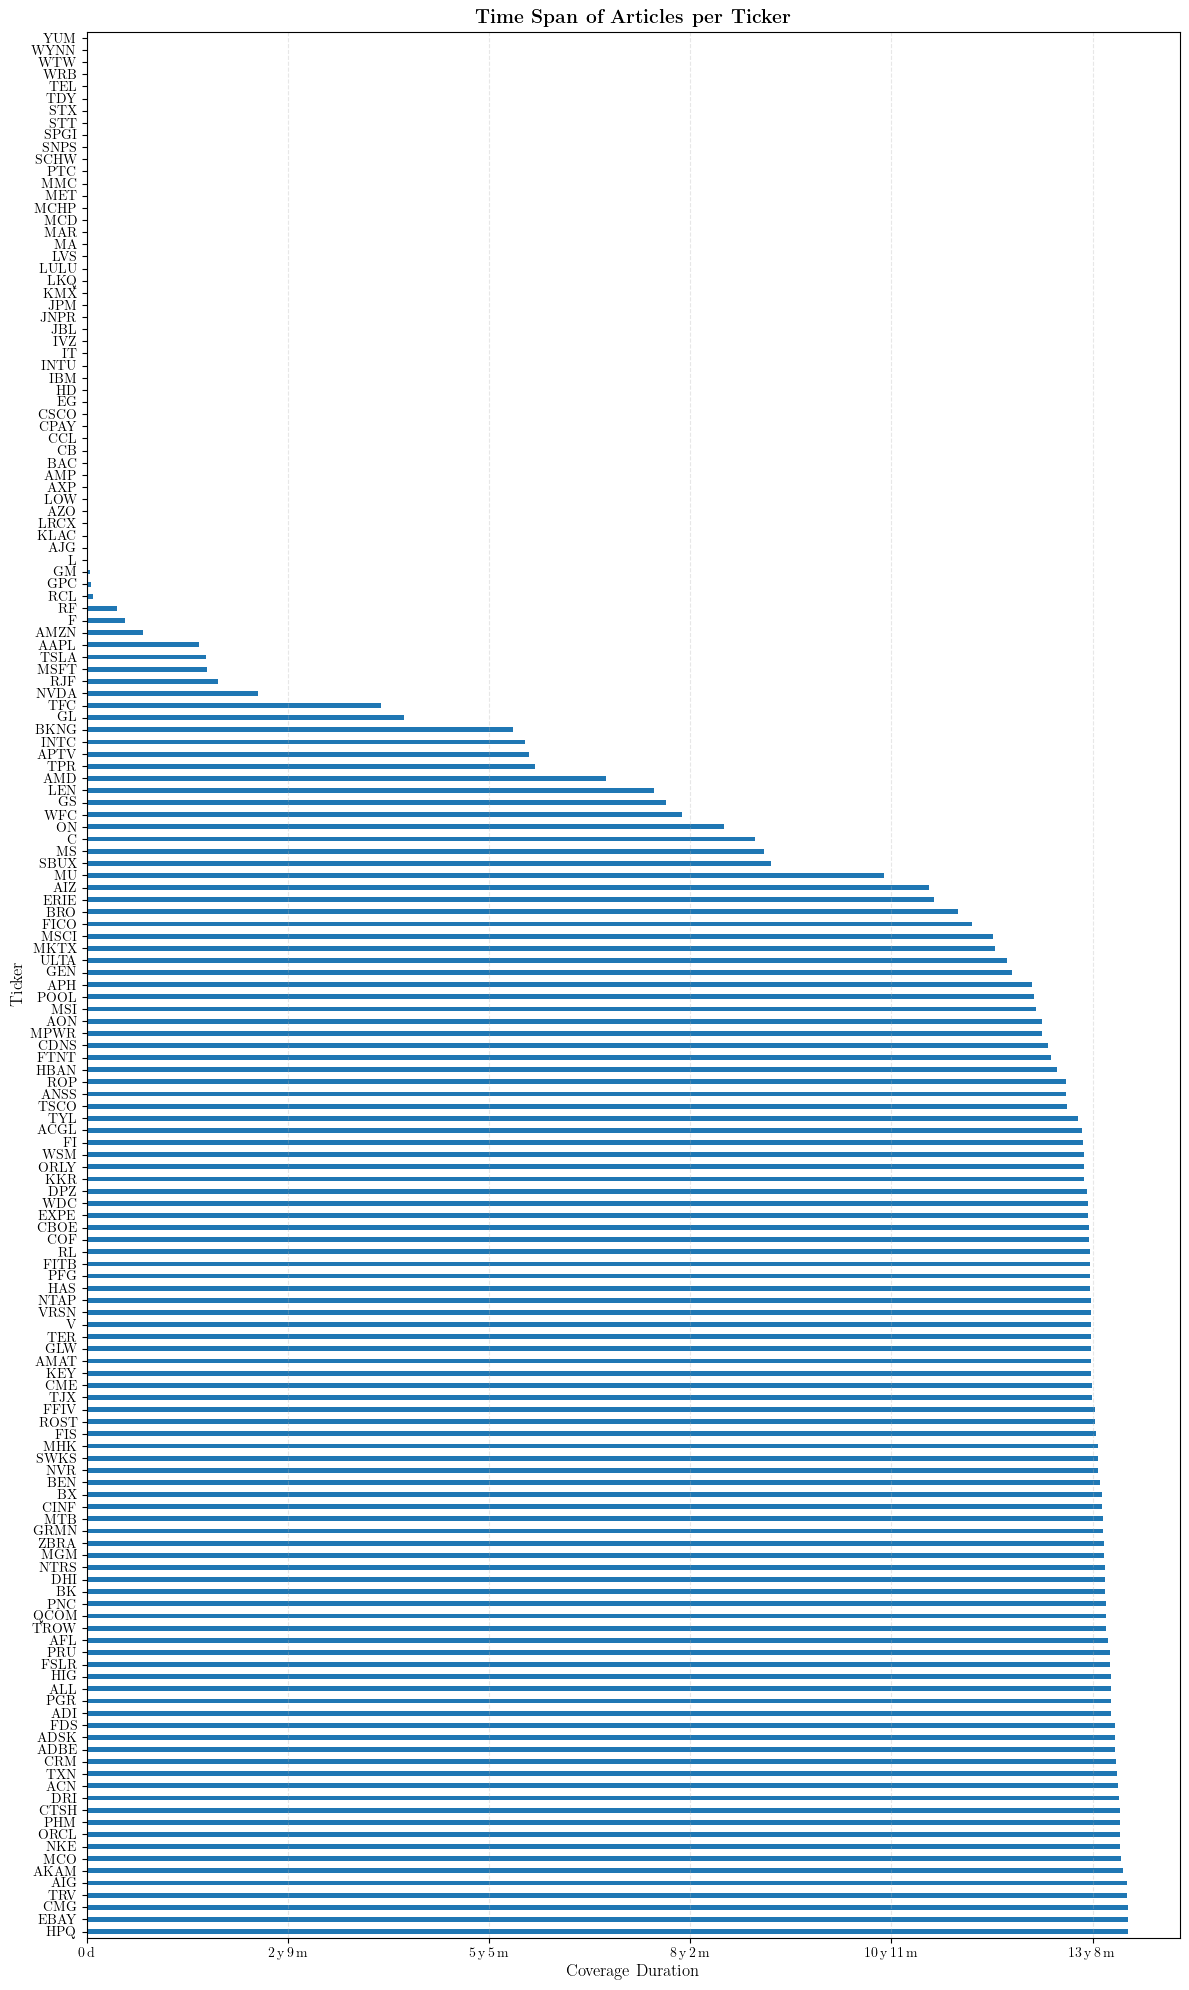

[INFO] Tickers with 0-day range: 37
[INFO] Max range: 5,176 days, Min: 0 days


In [32]:
plot_article_coverage_span(df=df,
                         all_tickers=all_tickers)

In [33]:
def plot_all_articles_scatter(df, all_tickers, reference_date=datetime(2012, 1, 1)):
    """
    Scatter plot showing all articles by date and ticker, sorted by article count.
    Includes tickers with zero articles. Adds a vertical reference line and article counts.
    """
    print("[INFO] Generating article scatter plot...")

    df['Date'] = pd.to_datetime(df['Date'], utc=True)

    # Count articles per ticker, fill missing with 0
    article_counts = df['Stock_symbol'].value_counts().reindex(all_tickers, fill_value=0)

    # Sort tickers by descending article count
    sorted_tickers = article_counts.sort_values(ascending=False).index.tolist()

    # Re-map tickers to y-axis positions
    ticker_to_y = {ticker: i for i, ticker in enumerate(sorted_tickers)}
    df = df[df['Stock_symbol'].isin(ticker_to_y)]
    df['y'] = df['Stock_symbol'].map(ticker_to_y)

    # Plot
    fig_height = max(6, min(len(sorted_tickers) * 0.25, 20))
    fig, ax = plt.subplots(figsize=(16, fig_height))

    ax.scatter(df['Date'], df['y'], s=1, alpha=0.6)
    ax.set_yticks(range(len(sorted_tickers)))
    ax.set_yticklabels(sorted_tickers)

    # Vertical reference line
    ax.axvline(reference_date, color='red', linestyle=':', linewidth=1.5,
               label=rf"\textit{{Reference:}} {reference_date.strftime('%Y-%m-%d')}")

    # Add article count labels on the right
    for i, ticker in enumerate(sorted_tickers):
        count = article_counts[ticker]
        ax.text(df['Date'].max() + pd.Timedelta(days=100), i,
                rf"${count}$", va='center', fontsize=8, color='gray')

    ax.set_xlim(df['Date'].min(), df['Date'].max() + pd.Timedelta(days=300))
    ax.set_ylim(-0.5, len(sorted_tickers) - 0.5)

    ax.set_xlabel(r"Date", fontsize=12)
    ax.set_ylabel(r"Ticker", fontsize=12)
    ax.set_title(r"\textbf{Scatter Plot of Articles by Ticker and Date (Sorted by Volume)}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


[INFO] Generating article scatter plot...


/var/folders/vn/mzcbmnv93_z0291brswcw9fw0000gn/T/ipykernel_91292/3182396579.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['Stock_symbol'].map(ticker_to_y)


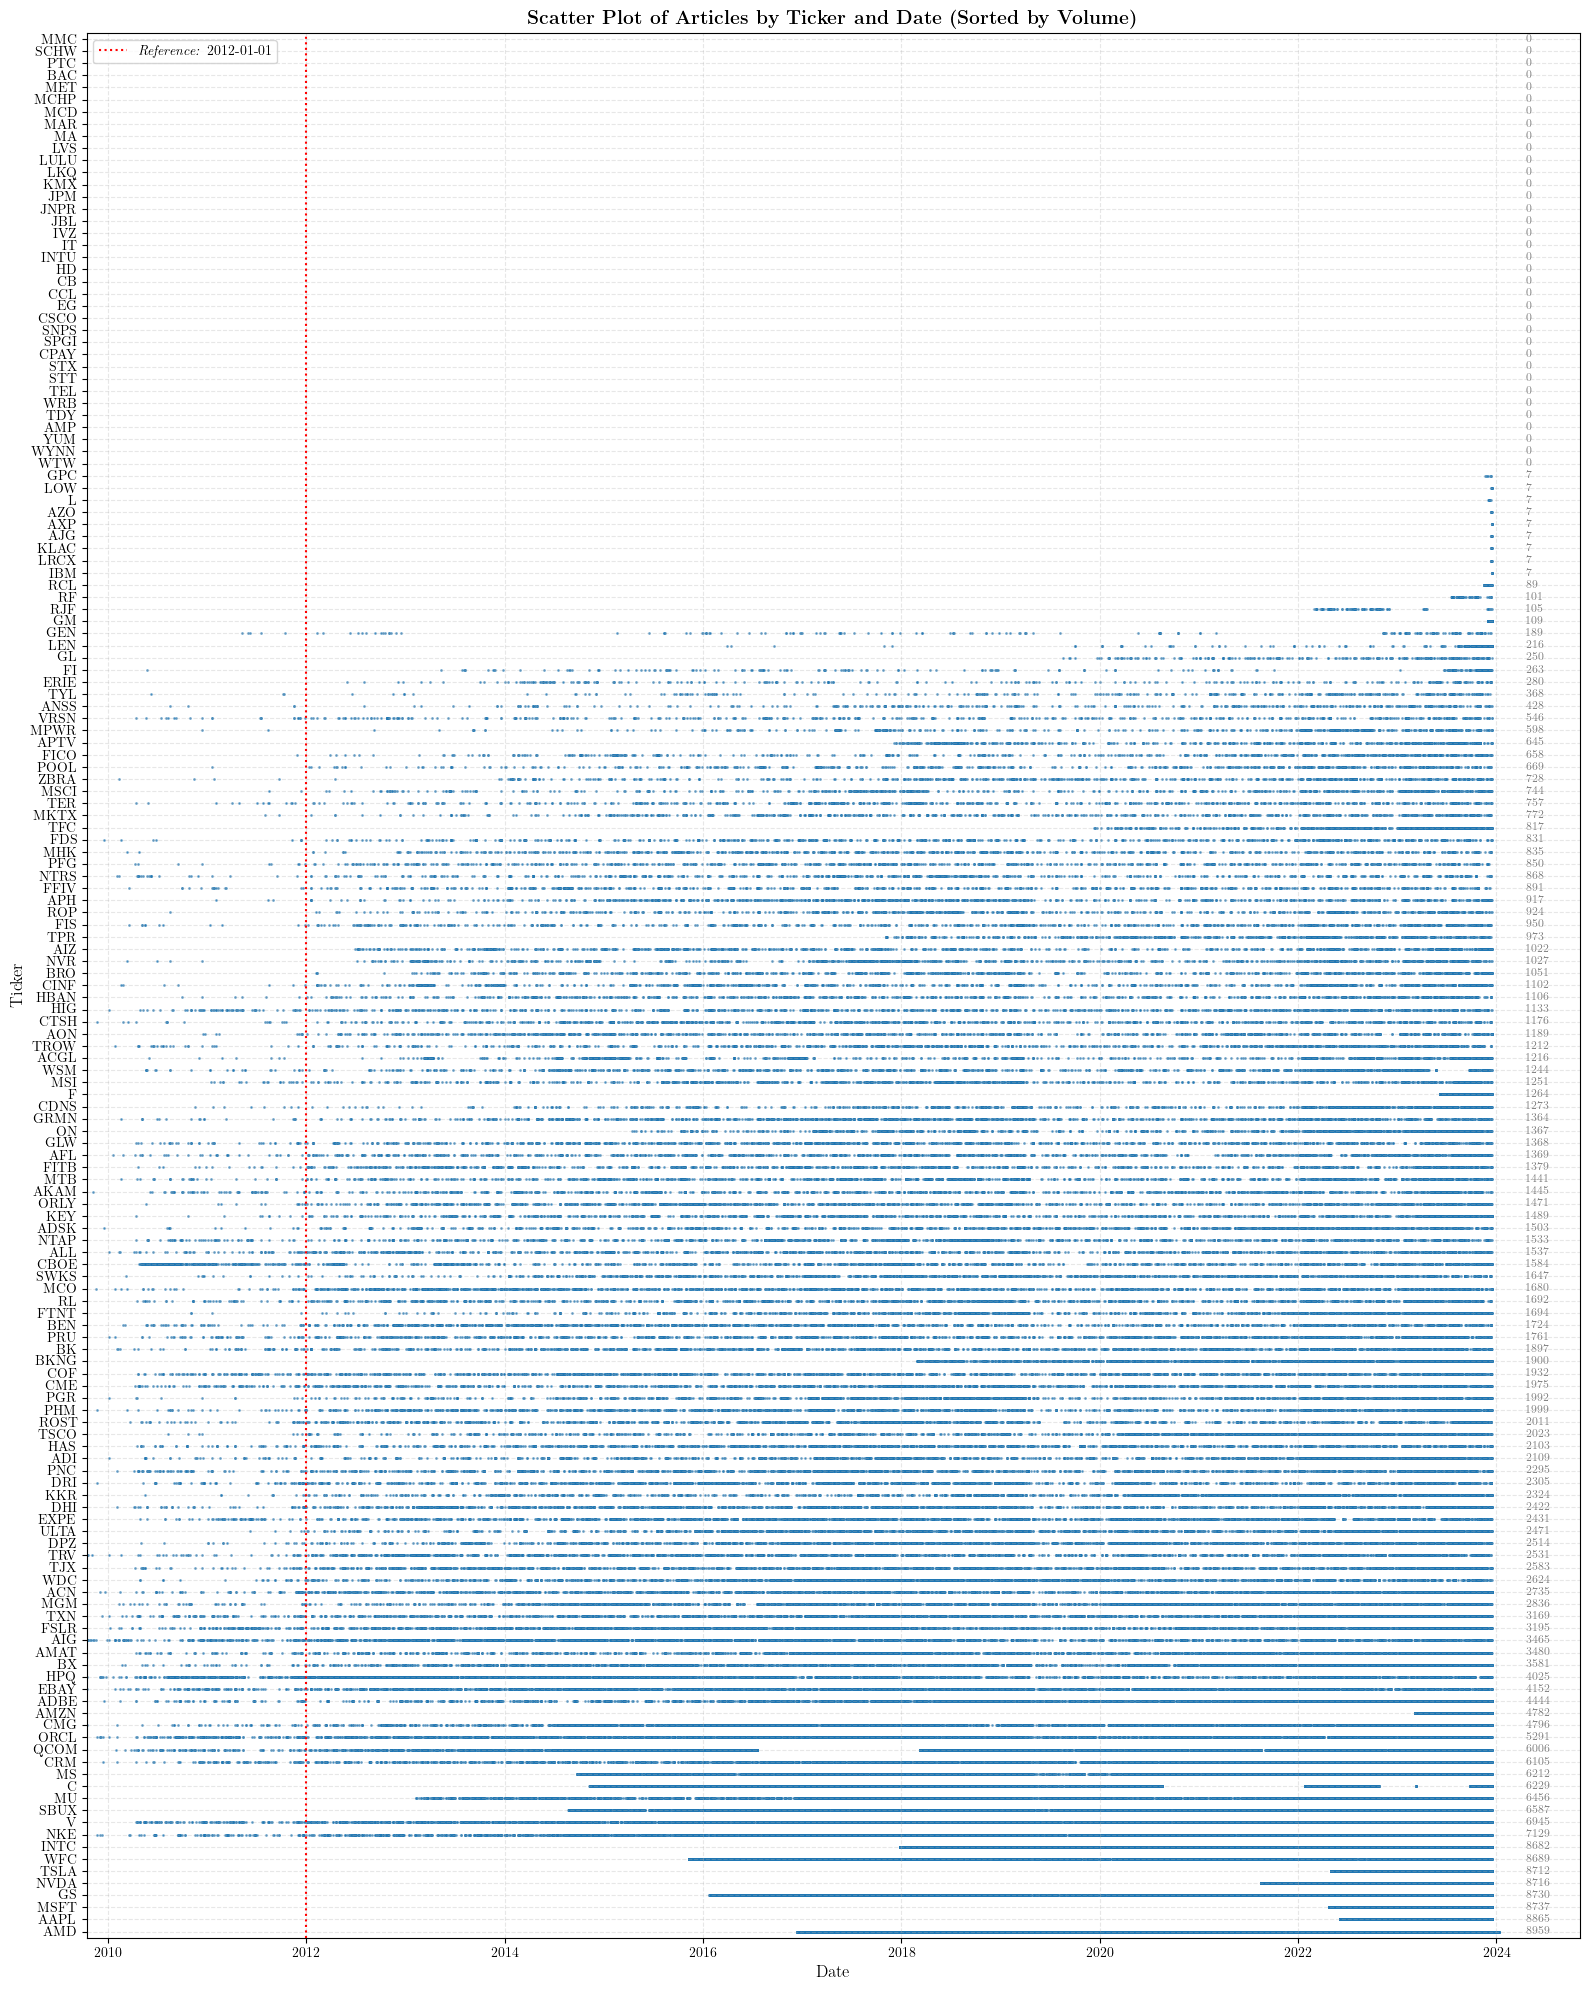

In [34]:
plot_all_articles_scatter(df, all_tickers, reference_date=datetime(2012, 1, 1))


In [13]:
def get_earliest_article(df, ticker):
    ticker_df = df[df['Stock_symbol'] == ticker]
    if ticker_df.empty:
        return None
    return pd.to_datetime(ticker_df['Date'], utc=True, errors='coerce').min()



In [38]:
def plot_earliest_article_dates(df, all_tickers, cutoff_date):
    """
    Plots the earliest article dates for each ticker.
    Also prints how many assets have earliest articles before the given cutoff_date.
    """
    print("[INFO] Gathering earliest dates per ticker...")

    earliest_dates = []
    today = datetime.now(timezone.utc)
    before_cutoff_count = 0

    for ticker in tqdm(all_tickers):
        date = get_earliest_article(df, ticker)
        if pd.isna(date):
            date = today
        else:
            date = pd.to_datetime(date).tz_convert('UTC') if pd.Timestamp(date).tzinfo else pd.to_datetime(date).replace(tzinfo=timezone.utc)
        if date < cutoff_date:
            before_cutoff_count += 1
        earliest_dates.append((ticker, date))

    print(f"[INFO] Assets with articles before {cutoff_date.date()}: {before_cutoff_count:,} / {len(all_tickers)}")

    # Sort by date
    earliest_dates.sort(key=lambda x: x[1])
    tickers_sorted, dates_sorted = zip(*earliest_dates)

    # map tickers to y-positions with extra spacing
    spacing = 1.2
    y_positions = [i * spacing for i in range(len(tickers_sorted))]

    plt.figure(figsize=(14, max(6, len(tickers_sorted) * 0.12)))
    plt.scatter(dates_sorted, y_positions, s=10)

    plt.axvline(cutoff_date, color='red', linestyle='--',
                label=rf"\textit{{Cutoff:}} {cutoff_date.strftime('%Y-%m-%d')}")

    plt.yticks(y_positions, tickers_sorted)

    plt.title(r"\textbf{Earliest Article Date for Each Ticker}", fontsize=14)
    plt.xlabel(r"Date", fontsize=12)
    plt.ylabel(r"Ticker", fontsize=12)

    plt.ylim(-spacing, y_positions[-1] + spacing)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


[INFO] Gathering earliest dates per ticker...


100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


[INFO] Assets with articles before 2012-01-01: 84 / 157


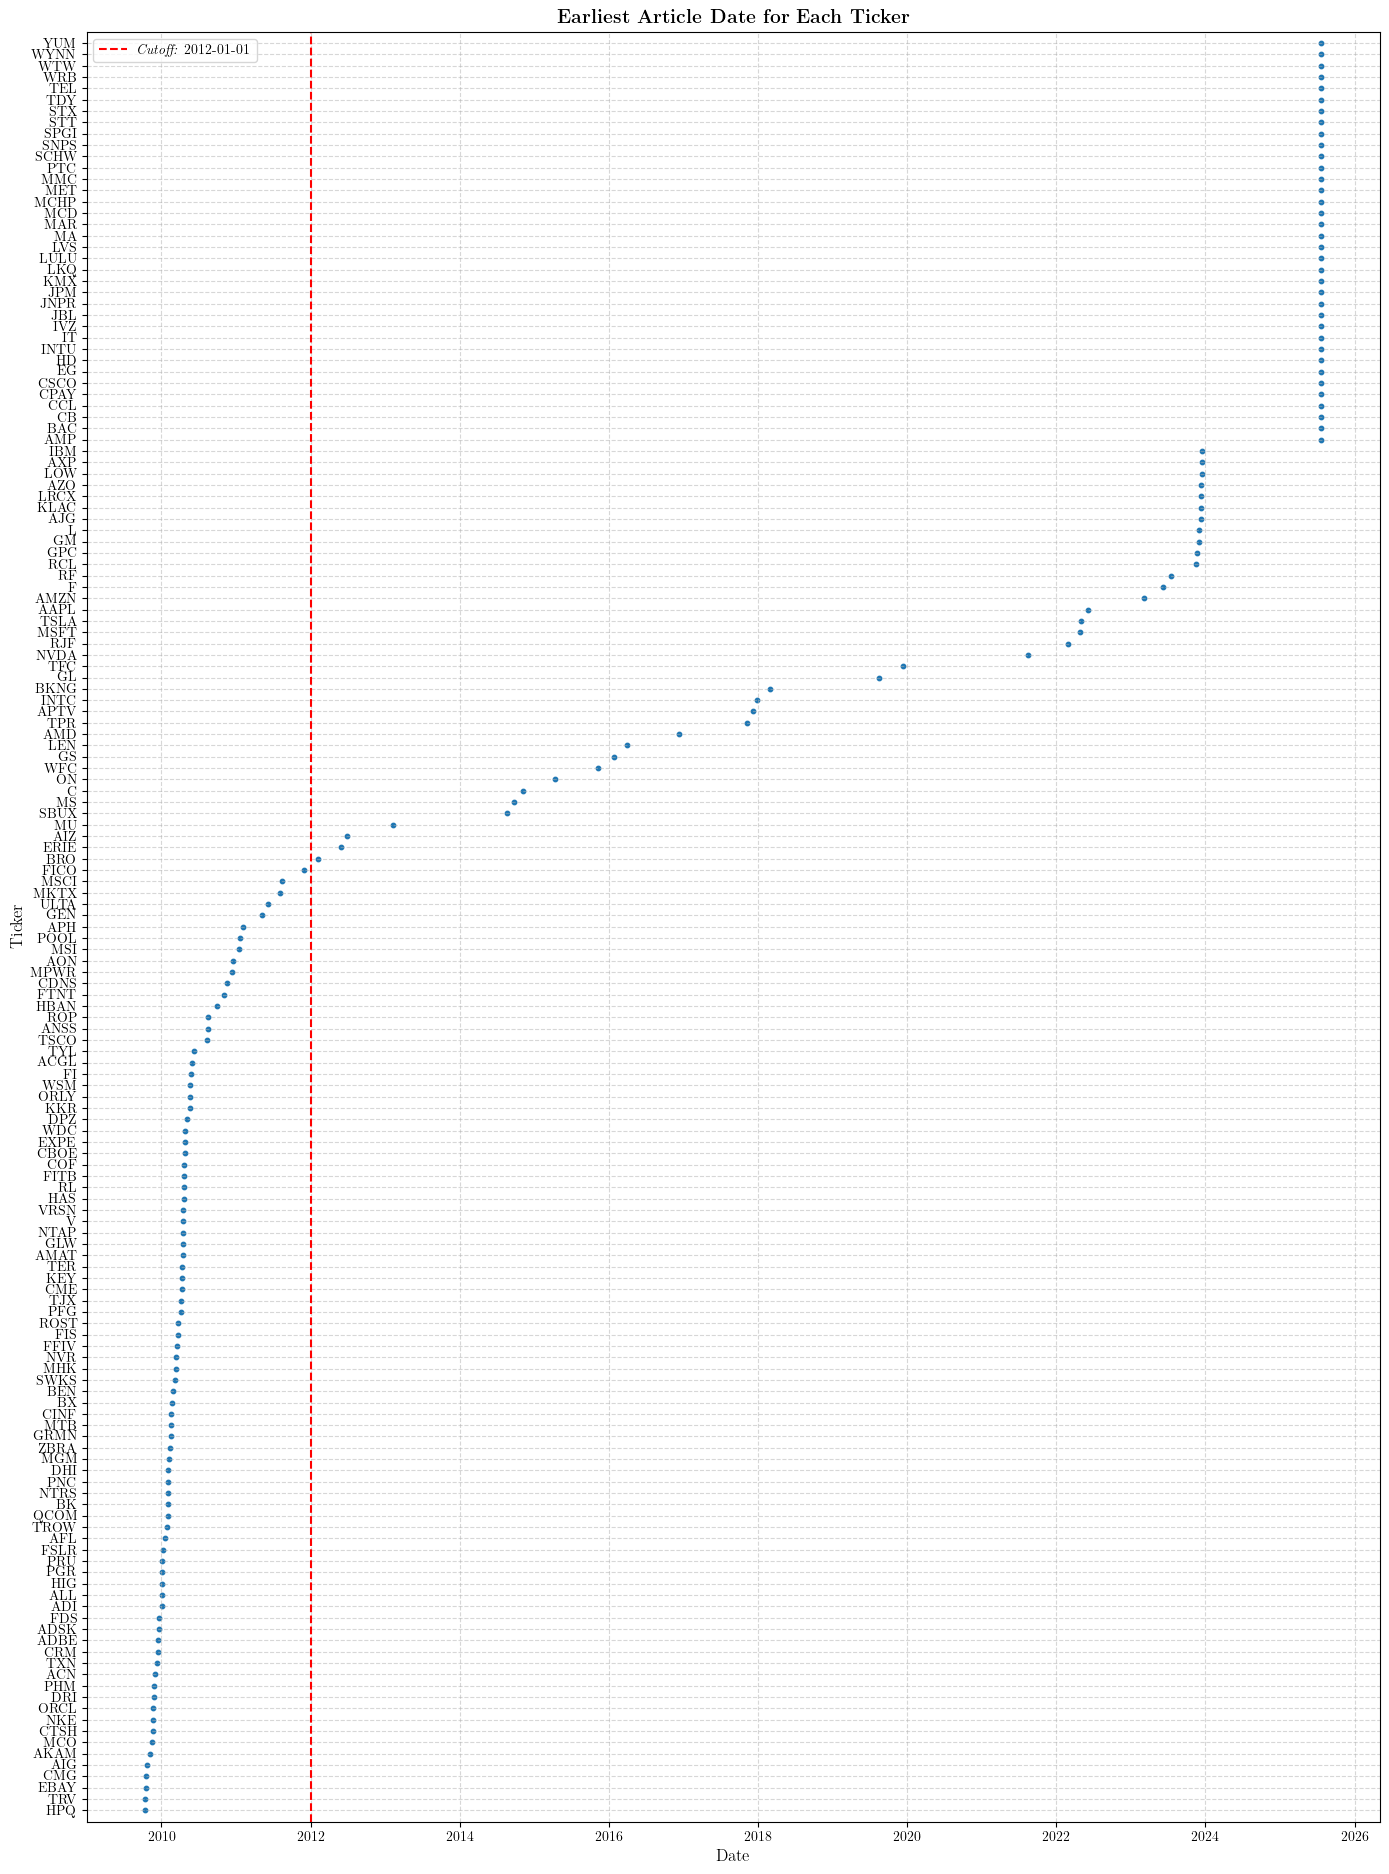

In [39]:
cutoff = datetime(2012, 1, 1, tzinfo=timezone.utc)
plot_earliest_article_dates(df=df,
                            all_tickers=all_tickers,
                            cutoff_date=cutoff)

## Initial thoughts
This has shown that we don't have total news coverage, especially for larger companies such as AAPL, what we do have though is this 'earliest article date' value for each ticker, we can make it so that nodes representing companies can only appear on the knowledge graph after this date

Companies with no news articles relating to them will have to be removed altogether by this logic - infact I'd say that companies with less than 50ish articles should be removed 

We may beed to locate a new data source, good news is that we now have the pipeline to clean a new dataset

## Important!
Another but of analysis I want to do is to use LLMs to analyse texts to see if there are any additional companies news articles relate to e.g an article could be centred around AAPL but if it details a partnership with GOOGL then that is of note to the GOOGL company node and should be treated as such. We can make a seperate pipeline that crunches through this and creates a new column that has a list of tickers that are of interest to that article outside of the main one. This allows news articles to be connected to multiple nodes, allowing for inter-company communication on the knowledge graph. This is the next but of major work to be done



In [16]:
def extract_article_lengths(df:pd.DataFrame):
    """
    Returns a new DataFrame with just Stock_symbol and Article_length (word count).
    """
    df = df.copy()
    df['Article_length'] = df['Article'].astype(str).apply(lambda x: len(x.split()))
    return df[['Stock_symbol', 'Article_length']]


In [17]:
length_df = extract_article_lengths(df=df)

In [40]:
def plot_mean_article_length_by_ticker(length_df, all_tickers):
    """
    Plots mean article length per ticker using a horizontal bar chart.
    Annotates each bar with the number of articles used to compute the mean.
    """
    print("[INFO] Calculating mean article lengths and article counts per ticker...")

    # Grouped stats
    grouped = length_df.groupby('Stock_symbol')['Article_length']
    mean_lengths_dict = grouped.mean().to_dict()
    counts_dict = grouped.count().to_dict()

    mean_lengths = {}
    article_counts = {}

    for ticker in tqdm(all_tickers):
        mean_lengths[ticker] = mean_lengths_dict.get(ticker, 0)
        article_counts[ticker] = counts_dict.get(ticker, 0)

    # Sort by mean article length
    sorted_items = sorted(mean_lengths.items(), key=lambda x: x[1])
    tickers_sorted, lengths_sorted = zip(*sorted_items)
    counts_sorted = [article_counts[t] for t in tickers_sorted]

    # Create y-positions with spacing
    spacing = 1.2
    y_positions = [i * spacing for i in range(len(tickers_sorted))]

    plt.figure(figsize=(14, max(6, len(tickers_sorted) * 0.12)))
    bars = plt.barh(y_positions, lengths_sorted, height=0.8)

    # Annotate with article counts
    for bar, count in zip(bars, counts_sorted):
        plt.text(bar.get_width() + 5,
                 bar.get_y() + bar.get_height() / 2,
                 rf"${count}$",
                 va='center', ha='left', fontsize=8, color='red')

    plt.yticks(y_positions, tickers_sorted)

    plt.title(r"\textbf{Mean Article Length per Ticker}", fontsize=14)
    plt.xlabel(r"Mean Article Length (words)", fontsize=12)
    plt.ylabel(r"Ticker", fontsize=12)

    plt.ylim(-spacing, y_positions[-1] + spacing)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


[INFO] Calculating mean article lengths and article counts per ticker...


100%|██████████| 157/157 [00:00<00:00, 1506878.10it/s]


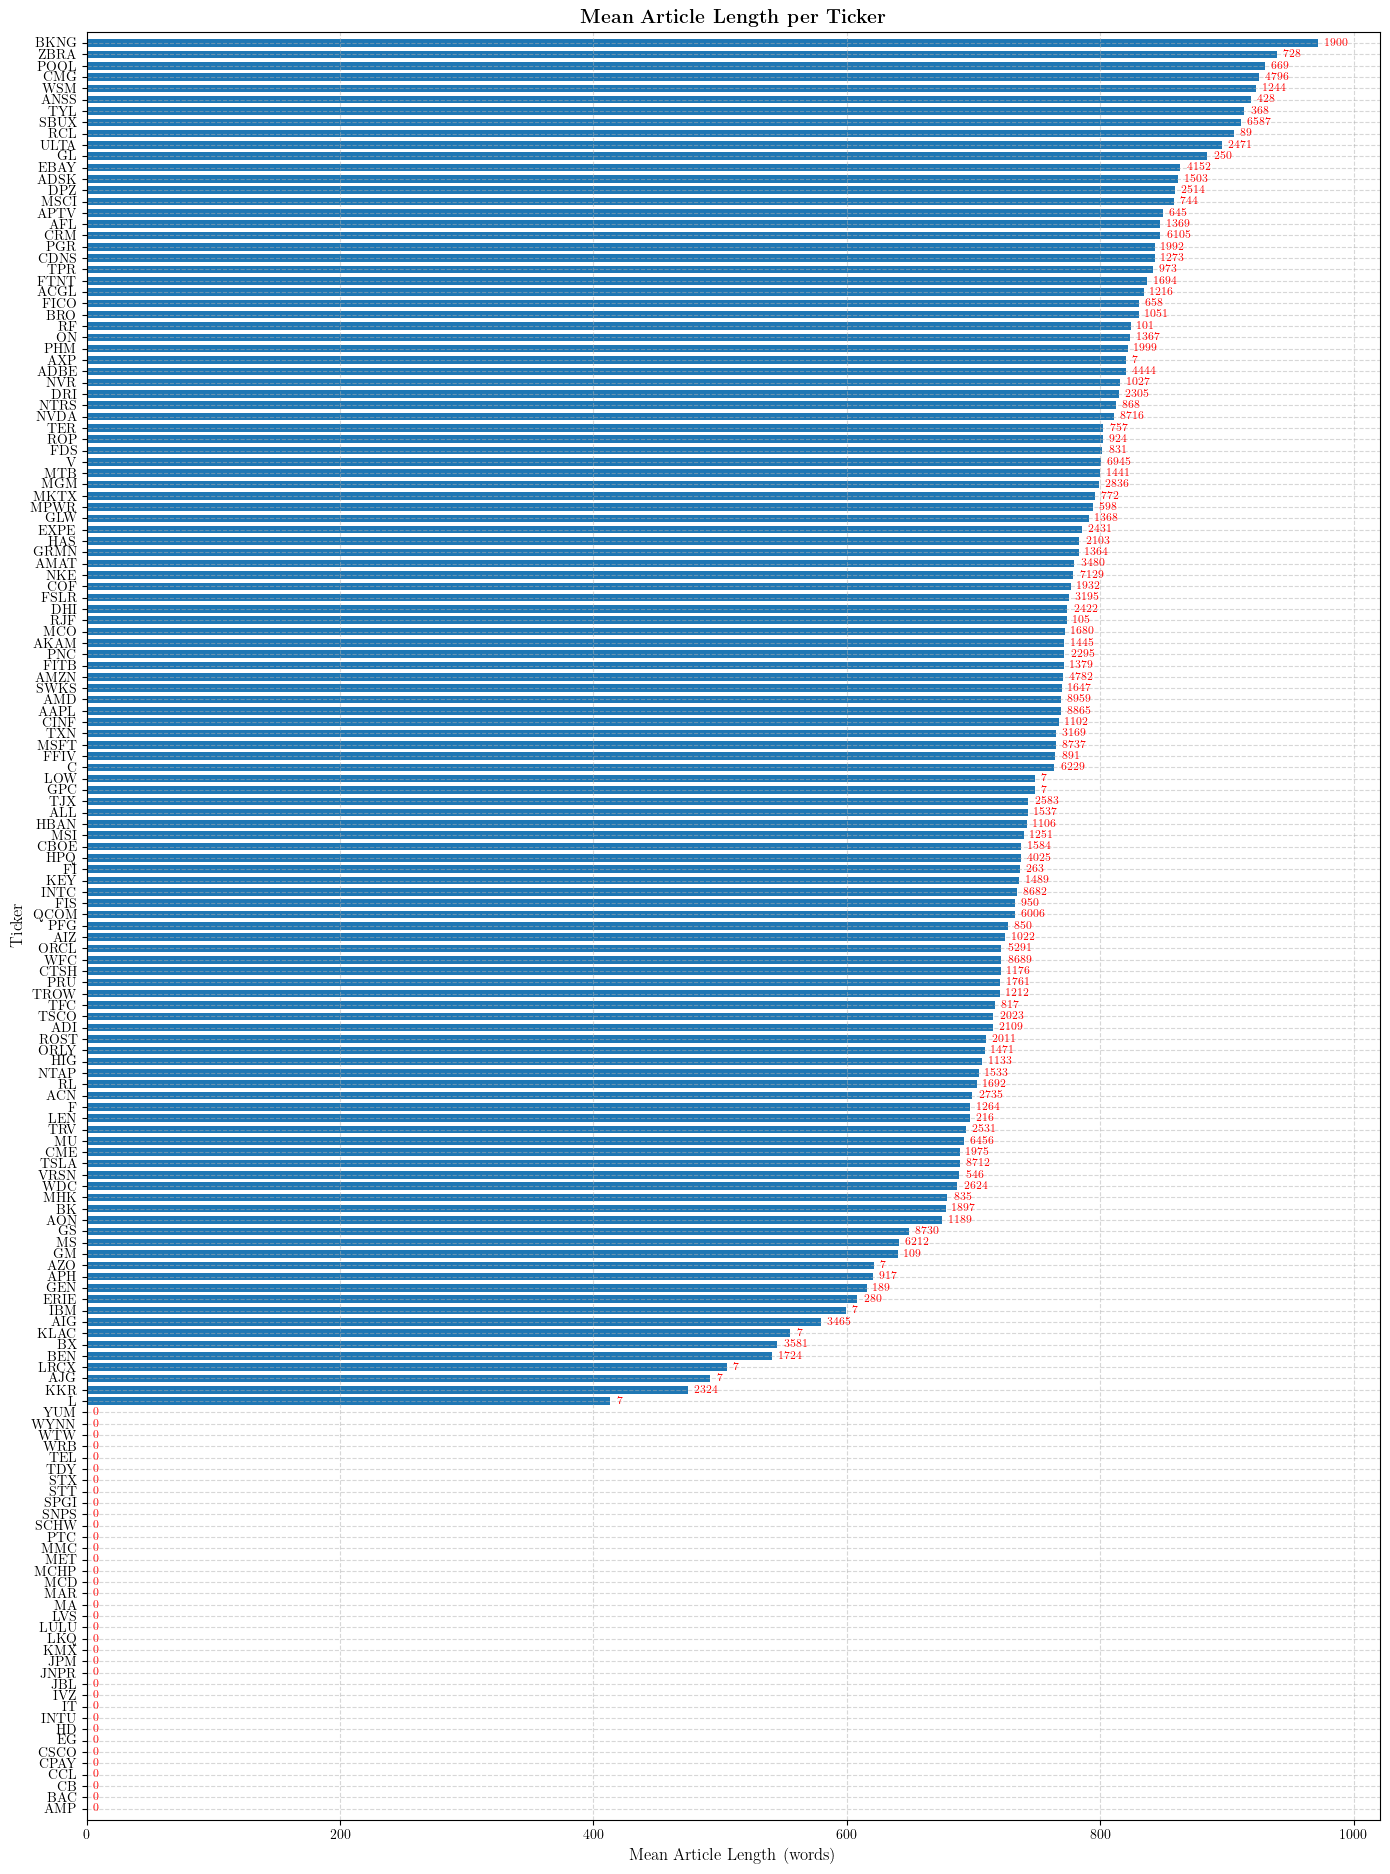

In [41]:

plot_mean_article_length_by_ticker(length_df=length_df,all_tickers=all_tickers)

This shows we have articles are rich in textual data


In [20]:
# Replace with your actual path
df_related = pd.read_csv("../../"+config.NEWS_CSV_PATH_ASSOCIATED_TICKERS)
# Quick info
print(f"Total rows: {len(df):,}")


Total rows: 280,428


In [45]:
def plot_associated_ticker_mentions(df: pd.DataFrame, all_tickers: list, exclude: str = "NDAQ"):
    """
    Count and plot mentions of each ticker in the 'Associated_tickers' column.
    Ensures all tickers in all_tickers are shown (0 if missing), excluding `exclude`.
    Annotates each bar with its count.
    """
    print(f"[INFO] Counting associated ticker mentions in {len(df)} articles, excluding '{exclude}'...")

    mentions = []
    for row in df['Associated_tickers']:
        if pd.notna(row) and row != "[]":
            try:
                tickers = ast.literal_eval(row)
                mentions.extend([t for t in tickers if t != exclude])
            except Exception as e:
                print(f"[WARN] Failed to parse: {row} — {e}")

    mention_counts = Counter(mentions)

    # Build full series including all tickers (except excluded)
    filtered_tickers = [t for t in all_tickers if t != exclude]
    full_counts = pd.Series(index=filtered_tickers, data=0)
    for ticker, count in mention_counts.items():
        if ticker in full_counts.index:
            full_counts[ticker] = count

    full_counts = full_counts.sort_values(ascending=False)

    # Info
    print(f"[INFO] Total unique tickers mentioned: {(full_counts > 0).sum()}/{len(filtered_tickers)}")
    print(f"[INFO] Top 5: {full_counts.head().to_dict()}")

    # Create y-positions with spacing
    spacing = 1.2
    y_positions = [i * spacing for i in range(len(full_counts))]

    fig_height = max(6, min(20, len(full_counts) * 0.12))
    fig, ax = plt.subplots(figsize=(12, fig_height))
    bars = ax.barh(y_positions, full_counts.values, color='blue', height=0.8)

    for bar, count in zip(bars, full_counts.values):
        ax.text(count + 1, bar.get_y() + bar.get_height() / 2,
                rf"${count}$", va='center', fontsize=8)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(full_counts.index)

    ax.set_ylim(-spacing, y_positions[-1] + spacing)

    ax.set_title(r"\textbf{Mentions of Associated Tickers Across Articles}", fontsize=14)
    ax.set_xlabel(r"Number of Mentions", fontsize=12)
    ax.set_ylabel(r"Ticker", fontsize=12)
    ax.invert_yaxis()  # biggest on top

    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()


[INFO] Counting associated ticker mentions in 202132 articles, excluding 'None'...
[INFO] Total unique tickers mentioned: 157/157
[INFO] Top 5: {'IT': 23622, 'ON': 19594, 'AAPL': 17930, 'AMZN': 17437, 'C': 16315}


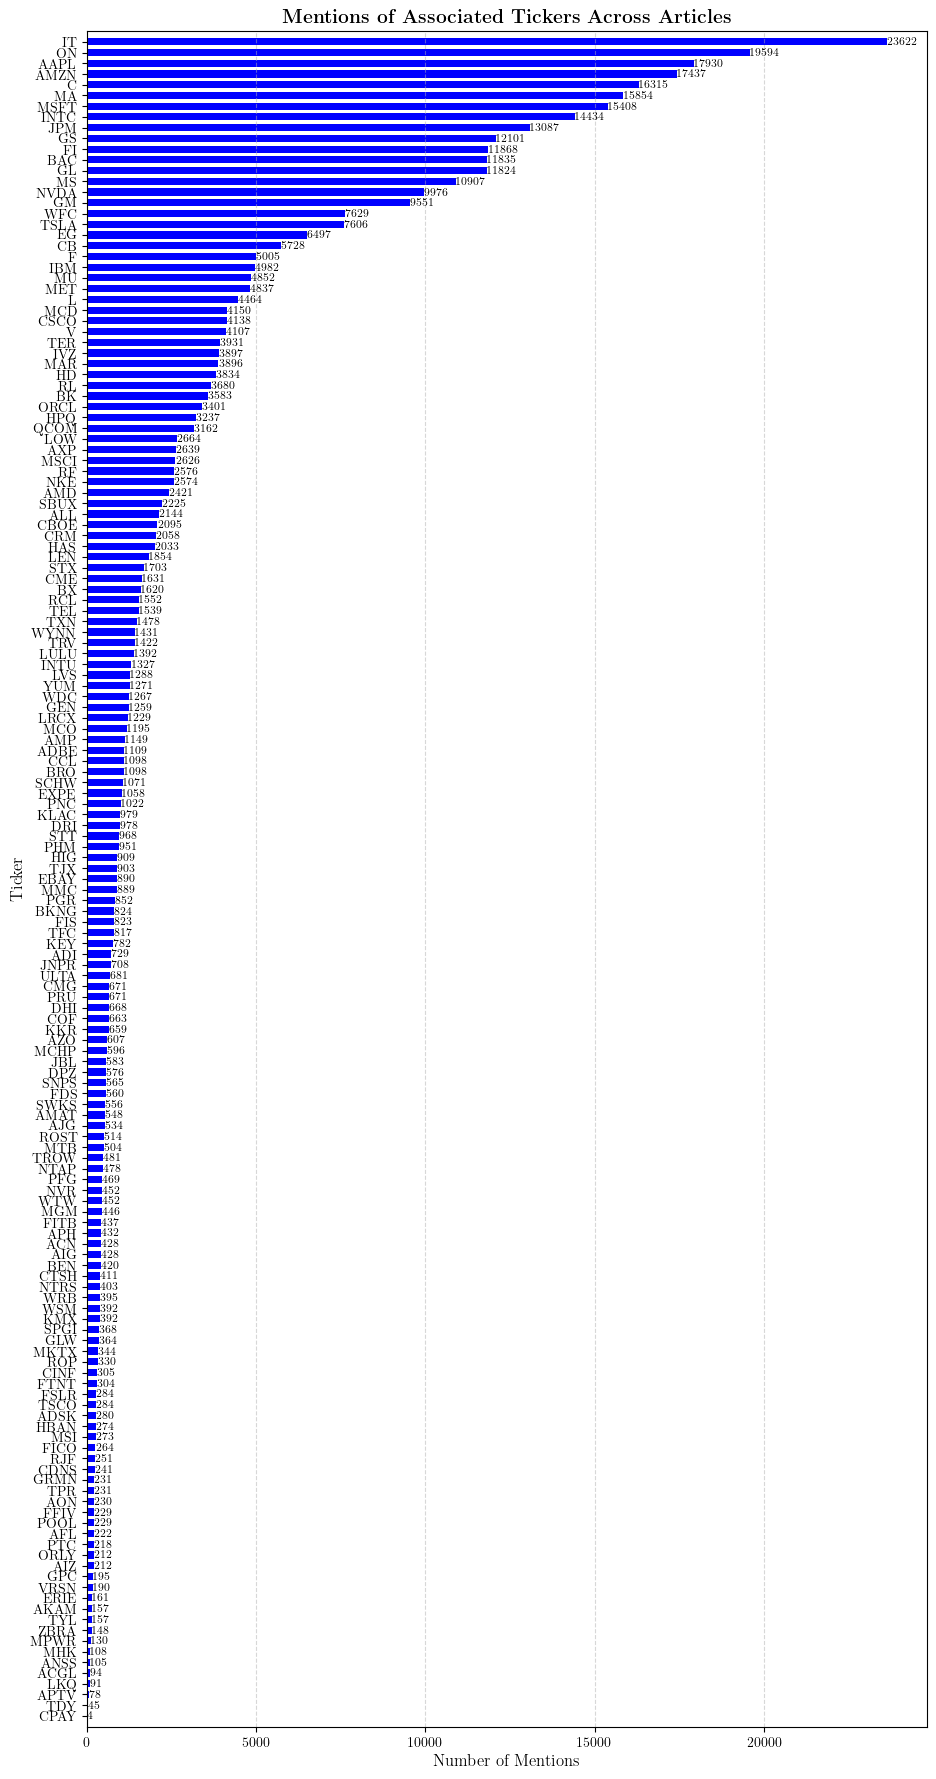

In [46]:
plot_associated_ticker_mentions(df=df_related, all_tickers=all_tickers, exclude=None)